In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
from torch import Tensor
from torch.nn import Parameter
import torch.utils.data as Data
from torch.utils.data import RandomSampler
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F
from sklearn.metrics import mean_squared_error
import pennylane as qml
import pytorch_lightning as pl
import math
import time



In [2]:
dfi = pd.read_csv('./Data/Weather/city_hour.csv')
dfi

,City,Datetime,PM2.5,PM10,NO,NO2,NOx,NH3,CO,SO2,O3,Benzene,Toluene,Xylene,AQI,AQI_Bucket
0,Ahmedabad,2015-01-01 01:00:00,NaN,NaN,1.00,40.01,36.37,NaN,1.00,122.07,NaN,0.0,0.0,0.0,NaN,NaN
1,Ahmedabad,2015-01-01 02:00:00,NaN,NaN,0.02,27.75,19.73,NaN,0.02,85.90,NaN,0.0,0.0,0.0,NaN,NaN
2,Ahmedabad,2015-01-01 03:00:00,NaN,NaN,0.08,19.32,11.08,NaN,0.08,52.83,NaN,0.0,0.0,0.0,NaN,NaN
3,Ahmedabad,2015-01-01 04:00:00,NaN,NaN,0.30,16.45,9.20,NaN,0.30,39.53,153.58,0.0,0.0,0.0,NaN,NaN
4,Ahmedabad,2015-01-01 05:00:00,NaN,NaN,0.12,14.90,7.85,NaN,0.12,32.63,NaN,0.0,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
707870,Visakhapatnam,2020-06-30 20:00:00,9.50,36.00,2.75,25.57,15.85,4.57,0.62,NaN,27.75,NaN,NaN,NaN,51.0,Satisfactory
707871,Visakhapatnam,2020-06-30 21:00:00,17.25,49.25,3.62,33.20,20.62,3.78,0.76,2.02,25.58,NaN,NaN,NaN,51.0,Satisfactory
707872,Visakhapatnam,2020-06-30 22:00:00,36.00,71.00,2.20,30.80,18.20,3.67,0.58,1.77,26.15,NaN,NaN,NaN,50.0,Good
707873,Visakhapatnam,2020-06-30 23:00:00,15.75,63.00,1.02,28.90,16.00,3.80,0.49,0.75,15.82,NaN,NaN,NaN,50.0,Good


In [3]:
dfi.dropna()
df = dfi.loc[ dfi['City'] == 'Delhi']  #will be using the delhi data first for simplicity
df = df.loc[df['Datetime'] < '2016-01-01 00:00:00']
df = df.dropna()

In [4]:
df = df.reset_index()
df = df.drop(['index','City','AQI_Bucket','Datetime','SO2', 'O3','Benzene','Toluene','Xylene','NO','NOx','NH3','NO2'], axis=1)
df

,PM2.5,PM10,CO,AQI
0,211.51,340.66,15.24,456.0
1,191.12,257.40,13.11,450.0
2,218.44,351.01,18.35,446.0
3,296.80,600.95,16.67,475.0
4,336.43,714.63,12.17,480.0
...,...,...,...,...
4944,142.61,359.15,2.64,412.0
4945,201.88,464.06,3.79,415.0
4946,272.73,535.32,2.89,432.0
4947,271.46,518.95,3.02,433.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4949 entries, 0 to 4948
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PM2.5   4949 non-null   float64
 1   PM10    4949 non-null   float64
 2   CO      4949 non-null   float64
 3   AQI     4949 non-null   float64
dtypes: float64(4)
memory usage: 154.8 KB


In [6]:
size = int(len(df) * 0.8)

train = df.iloc[:size].copy()
test = df.iloc[size:].copy()
train

,PM2.5,PM10,CO,AQI
0,211.51,340.66,15.24,456.0
1,191.12,257.40,13.11,450.0
2,218.44,351.01,18.35,446.0
3,296.80,600.95,16.67,475.0
4,336.43,714.63,12.17,480.0
...,...,...,...,...
3954,181.59,378.51,2.88,437.0
3955,183.38,347.46,2.49,432.0
3956,170.97,276.65,2.07,424.0
3957,160.19,243.97,1.56,414.0


In [7]:
train.iloc[:,-1:]

,AQI
0,456.0
1,450.0
2,446.0
3,475.0
4,480.0
...,...
3954,437.0
3955,432.0
3956,424.0
3957,414.0


In [8]:
train.iloc[:,:3]

,PM2.5,PM10,CO
0,211.51,340.66,15.24
1,191.12,257.40,13.11
2,218.44,351.01,18.35
3,296.80,600.95,16.67
4,336.43,714.63,12.17
...,...,...,...
3954,181.59,378.51,2.88
3955,183.38,347.46,2.49
3956,170.97,276.65,2.07
3957,160.19,243.97,1.56


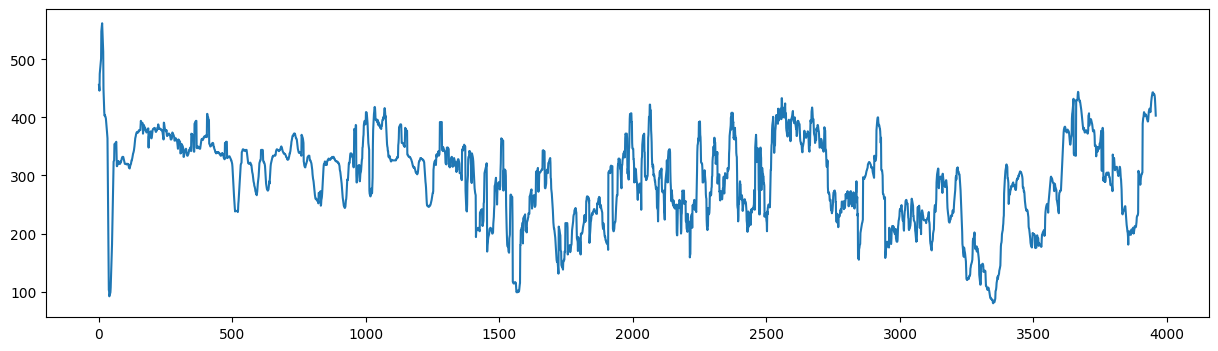

In [9]:
%matplotlib inline
plt.figure(figsize=(15, 4))
plt.plot(range(len(train)), train["AQI"])
plt.show()

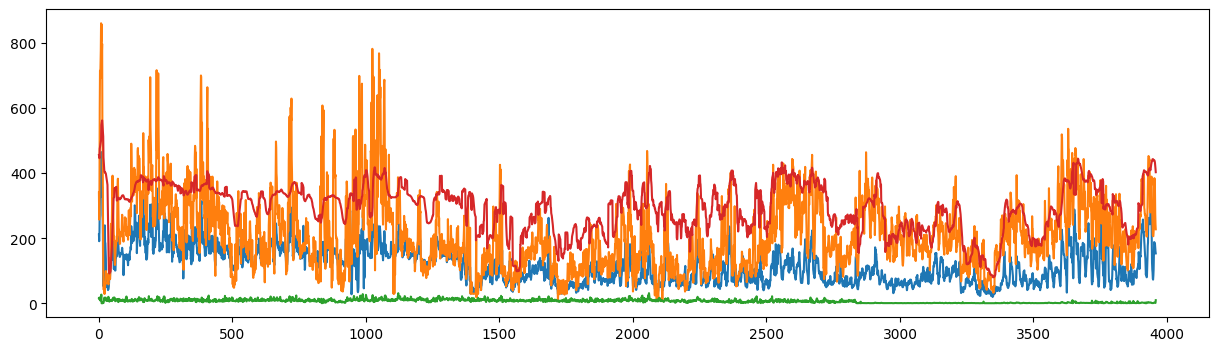

In [10]:
plt.figure(figsize=(15, 4))
plt.plot(train)
plt.show()

In [20]:
def data_process(data, window_size, predict_size):
    scaler1 = StandardScaler()
   
    d_y = data.iloc[:,-1:]
    data = scaler1.fit_transform(data.iloc[:,:3])

    data_in = []
    data_out = []
    # range(window_size,len(data)-predict_size+1) range(data.shape[0] - window_size - predict_size + 1)
    for i in range(window_size,len(data)-predict_size+1):
        data_in.append(data[i-window_size:i,0:data.shape[0]])
        data_out.append(d_y.iloc[i + predict_size - 1 : i + predict_size,0])

    data_in = np.array(data_in)
    data_out = np.array(data_out)

    data_process = {'datain': data_in, 'dataout': data_out}

    return data_process, scaler1

In [21]:
from numpy.random import default_rng
from qiskit_algorithms.utils import algorithm_globals
qubits = 3
seed = 42
np.random.seed(seed)
torch.manual_seed(42)
rng = default_rng(seed)
algorithm_globals.random_seed = seed
features_size = 3
#window_size = features_size * 3
window_size = 10
predict_size = 1

In [22]:
train_processed, train_scaler = data_process(train, window_size, predict_size)
X_train, y_train = train_processed['datain'], train_processed['dataout']

test_processed, test_scaler = data_process(test, window_size, predict_size)
X_test, y_test = test_processed['datain'], test_processed['dataout']

In [23]:
X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))

y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

In [24]:
print(X_train.shape)
X_train[0][0]

torch.Size([3949, 10, 3])


tensor([1.7163, 1.1380, 1.5963])

In [25]:
class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 1

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [39]:
batch_size = 4
learning_rate = 0.004
num_epochs = 50
trainDataloader = DataLoader(TensorDataset(X_train, y_train), batch_size = batch_size, shuffle = True)
testDataloader = DataLoader(TensorDataset(X_test,y_test), batch_size = batch_size, shuffle = False)
device = "cpu"
modelQ = ShallowRegressionLSTM(num_sensors=3, hidden_units= 12)
criterion = nn.MSELoss()
optimizerQ = torch.optim.Adam(modelQ.parameters(), lr = learning_rate, betas = (0.0, 0.9))

In [40]:
histQ = np.zeros(num_epochs)
histQacc = np.zeros(num_epochs)

count = 0
for epoch in range(num_epochs):
    loss = 0
    for (x, y) in trainDataloader:
        modelQ.zero_grad()
        x = x.to(device)
        y = y.to(device)
        output = modelQ(x)

        label = y.squeeze(1)
        #print(output)
        #print(label)
        lossQ = criterion(output, label)
        lossQ.backward()
        optimizerQ.step()
        
        #correct += (output == label).float().sum()
        #batches +=1
        
        loss += lossQ.item() / len(trainDataloader)
    histQ[epoch] = loss
    
    #print(correct)
    #histQacc[epoch] = correct/batches
    print(f'[{epoch+1}/{num_epochs}]  LossQ:{loss} ')

[1/50]  LossQ:76499.44207640116 
[2/50]  LossQ:52090.68610928801 
[3/50]  LossQ:32912.68899153117 
[4/50]  LossQ:18983.224641251672 
[5/50]  LossQ:10297.73891581792 
[6/50]  LossQ:6367.151250785181 
[7/50]  LossQ:5466.894623157947 
[8/50]  LossQ:5363.193802435876 
[9/50]  LossQ:5353.765296295108 
[10/50]  LossQ:5355.051041591506 
[11/50]  LossQ:5356.121244337878 
[12/50]  LossQ:5363.396421803153 
[13/50]  LossQ:5370.108663952783 
[14/50]  LossQ:5355.728841974669 
[15/50]  LossQ:5354.609065345428 
[16/50]  LossQ:5355.3413671269545 
[17/50]  LossQ:5354.294728607308 
[18/50]  LossQ:5354.940237454553 
[19/50]  LossQ:5354.428450858541 
[20/50]  LossQ:5358.082118092275 
[21/50]  LossQ:5362.113937408821 
[22/50]  LossQ:5355.474510131101 
[23/50]  LossQ:5353.5170855580045 
[24/50]  LossQ:5365.962921930239 
[25/50]  LossQ:5360.046782860385 
[26/50]  LossQ:5357.892281258149 
[27/50]  LossQ:5355.823451501638 
[28/50]  LossQ:5355.640323252814 
[29/50]  LossQ:5361.504999848023 
[30/50]  LossQ:5363.

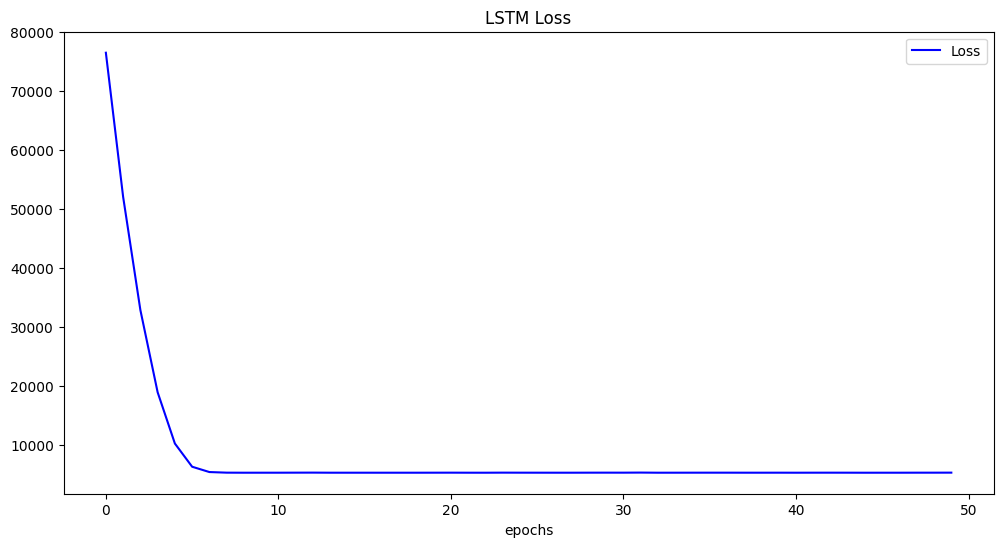

In [50]:
#np.savetxt('./SavedModels/Loss/clstm.txt',histQ)
plt.figure(figsize = (12, 6))
plt.plot(histQ, color = 'blue', label = 'Loss')
plt.title('LSTM Loss')
plt.xlabel('epochs')
plt.legend(loc = 'upper right')

In [51]:
pred_y_train = modelQ(X_train)
pred_y_test = modelQ(X_test)

print(pred_y_train)

tensor([294.6333, 294.6333, 294.6333,  ..., 294.6333, 294.6333, 294.6333],
       grad_fn=<ViewBackward0>)


In [52]:
pred_y_train = pred_y_train.reshape(-1, 1)
pred_y_test = pred_y_test.reshape(-1, 1)


In [53]:
pred_y_train

tensor([[294.6333],
        [294.6333],
        [294.6333],
        ...,
        [294.6333],
        [294.6333],
        [294.6333]], grad_fn=<ViewBackward0>)

In [54]:
y_train_true = y_train
y_train_pred =pred_y_train.cpu().detach().numpy()
y_test_true =y_test
y_test_pred = pred_y_test.cpu().detach().numpy()

In [55]:
#np.savetxt('./SavedModels/Train/clstm.txt',y_train_pred)
#np.savetxt('./SavedModels/Test/clstm.txt',y_test_pred)

Training dataset RMSE:73.18988841107083


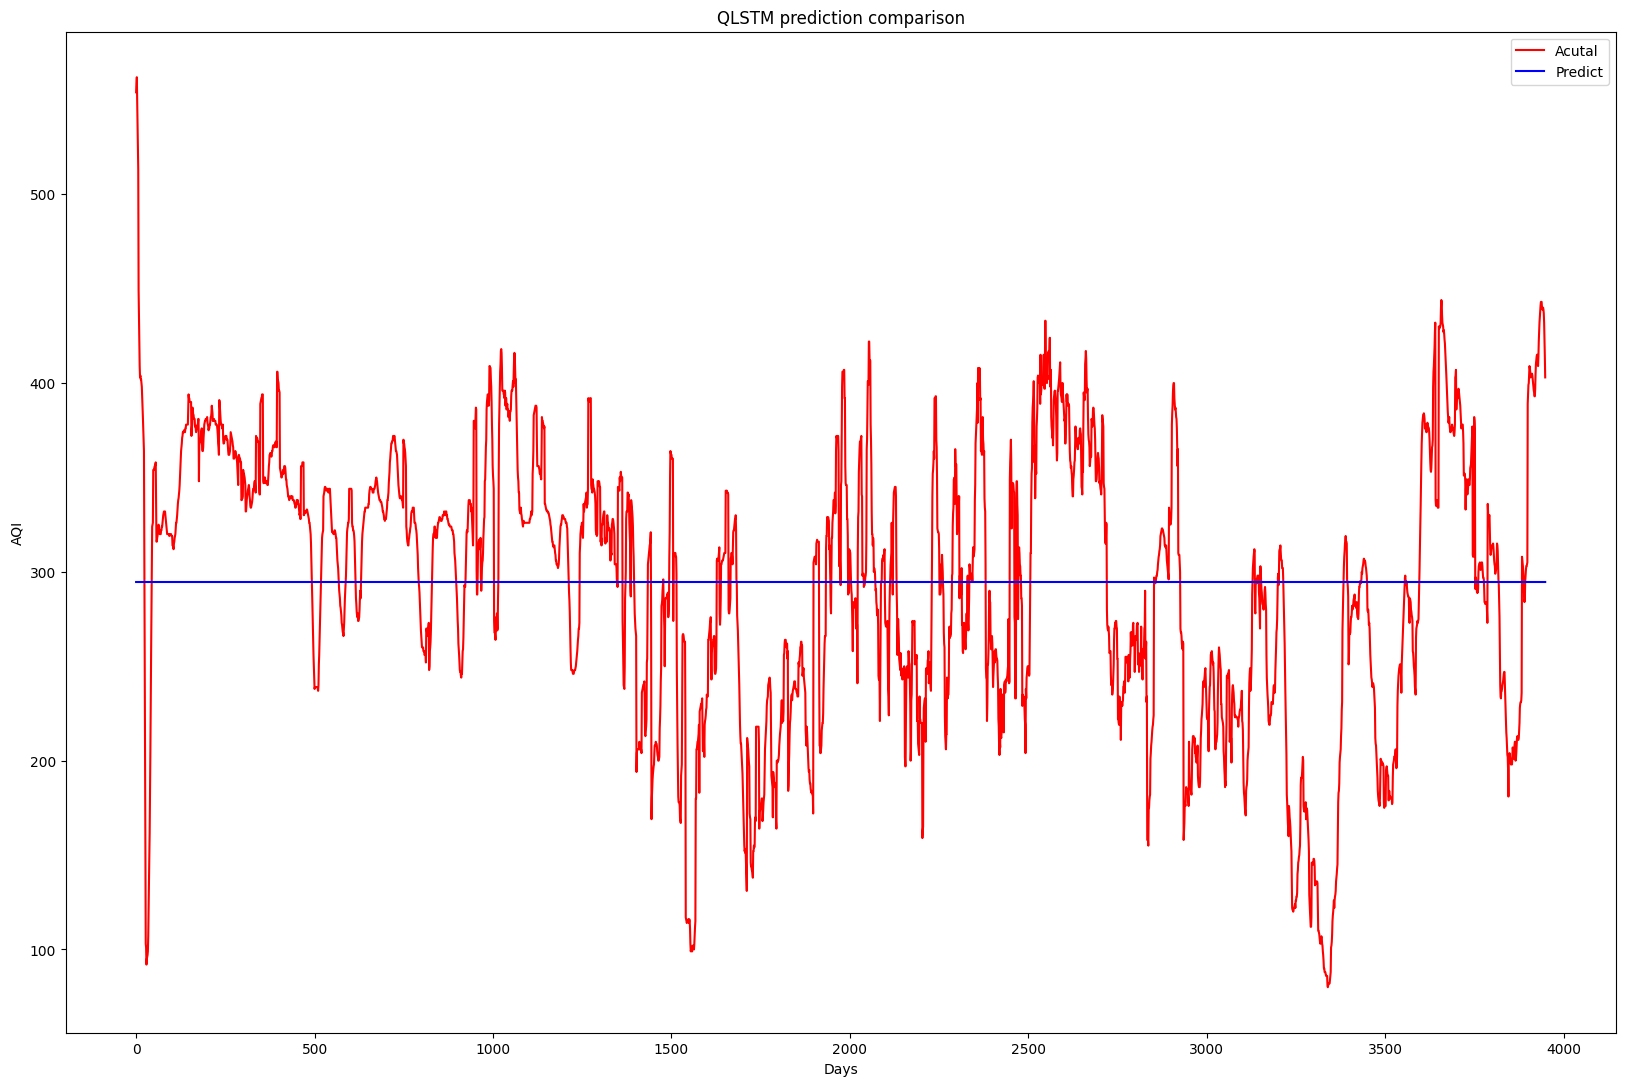

In [56]:
plt.figure(figsize=(20, 13))
plt.plot(y_train_true, color = 'red', label = 'Acutal')
plt.plot(y_train_pred, color = 'blue', label = 'Predict')
plt.title('QLSTM prediction comparison')
plt.ylabel('AQI')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_train_true, y_train_pred) #/ len(y_train_true)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

Training dataset RMSE:112.41157114872561


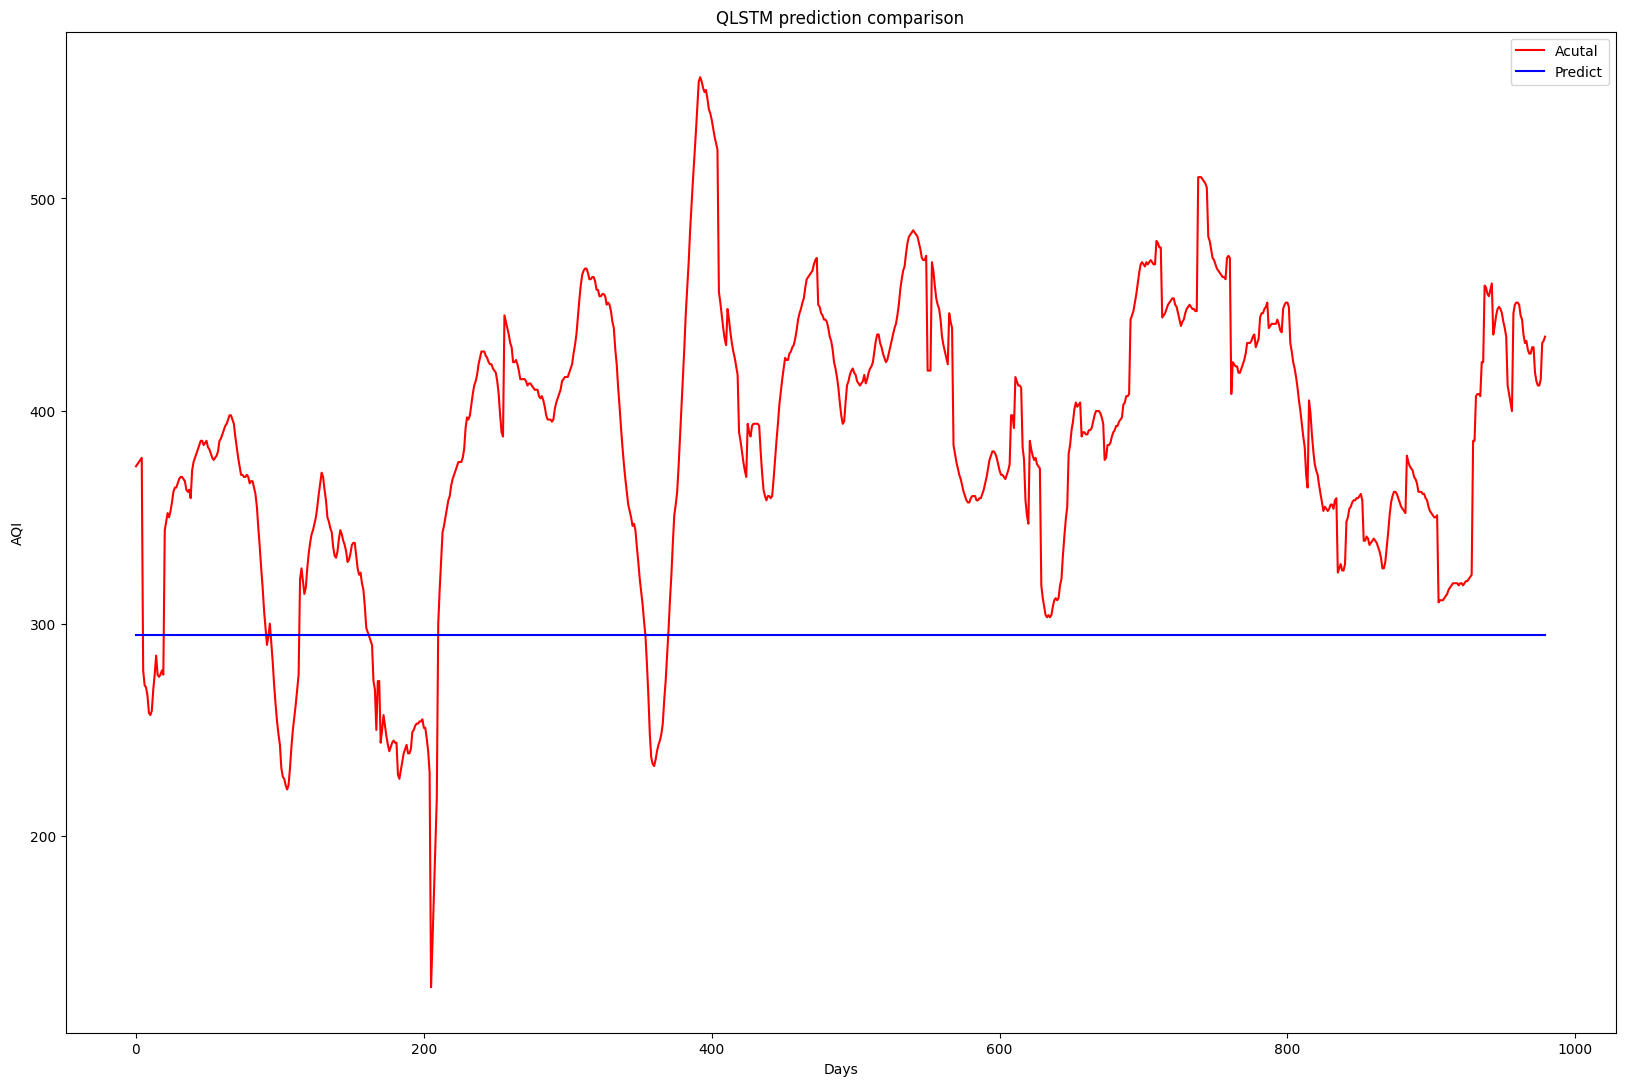

In [57]:
plt.figure(figsize=(20, 13))
plt.plot(y_test_true, color = 'red', label = 'Acutal')
plt.plot(y_test_pred, color = 'blue', label = 'Predict')
plt.title('QLSTM prediction comparison')
plt.ylabel('AQI')
plt.xlabel('Days')
plt.legend(loc = 'upper right')

MSE = mean_squared_error(y_test_true, y_test_pred) #/ len(y_test_true)
RMSE = math.sqrt(MSE)
print(f'Training dataset RMSE:{RMSE}')

In [58]:
#torch.save(modelQ,'./SavedModels/AQI/CLSTM_aqi')